<a href="https://colab.research.google.com/github/pinilDissanayaka/Traffic-Sign-Recognition/blob/main/Traffic_Sign_Recognition_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 15.1 MB/s eta 0:00:00


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
! kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
100% 609M/612M [00:06<00:00, 110MB/s]
100% 612M/612M [00:06<00:00, 104MB/s]


In [4]:
!unzip /content/gtsrb-german-traffic-sign.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
from glob import glob

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model, to_categorical
from livelossplot import PlotLossesKerasTF
import visualkeras

%matplotlib inline

import warnings
warnings.filterwarnings(action = 'ignore')

In [6]:
import tensorflow
print(f"Tensorflow version : {tensorflow.__version__}")

Tensorflow version : 2.15.0


In [7]:
train_df = pd.read_csv('/content/Train.csv')
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [8]:
train_df.duplicated().sum()

0

In [9]:
train_df.isnull().sum()

Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64

In [10]:
test_df = pd.read_csv('/content/Test.csv')
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [11]:
test_df.duplicated().sum()

0

In [12]:
test_df.isnull().sum()

Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64

ClassId
2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
3     1410
8     1410
11    1320
18    1200
35    1200
17    1110
14     780
31     780
33     689
15     630
26     600
28     540
23     510
30     450
16     420
6      420
34     420
22     390
36     390
40     360
20     360
21     330
39     300
29     270
24     270
32     240
27     240
41     240
42     240
37     210
0      210
19     210
Name: count, dtype: int64


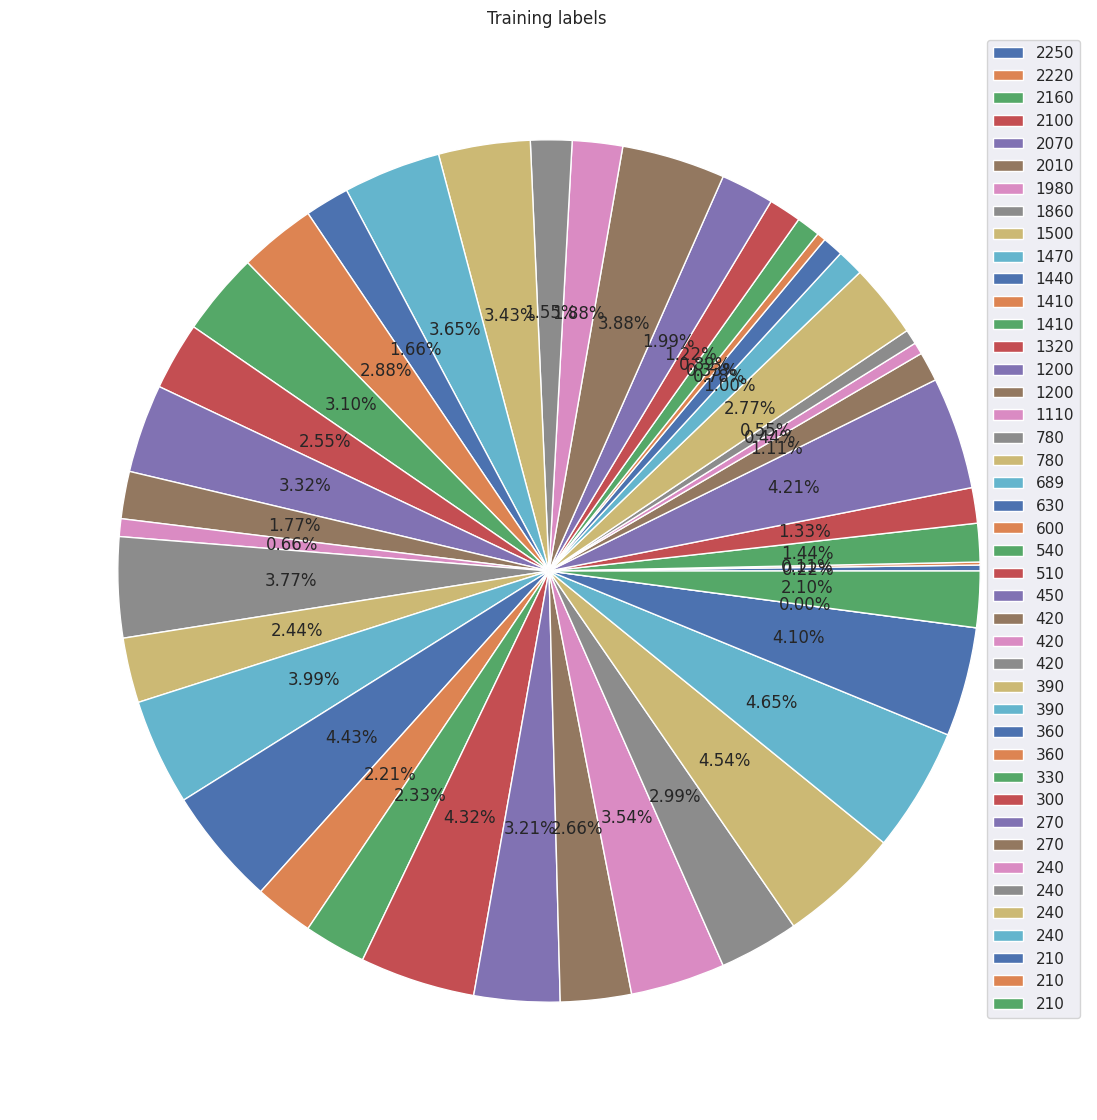

In [13]:
print(train_df['ClassId'].value_counts())

sns.set()
plt.figure(figsize = (14, 14))
plt.pie(x = train_df['ClassId'].value_counts().index, autopct= '%1.2f%%')
plt.legend( labels = train_df['ClassId'].value_counts().values)
plt.title("Training labels ")
plt.show()

ClassId
2     750
1     720
13    720
38    690
12    690
4     660
10    660
5     630
9     480
25    480
3     450
8     450
7     450
11    420
35    390
18    390
17    360
31    270
14    270
15    210
33    210
26    180
30    150
16    150
28    150
6     150
23    150
22    120
36    120
34    120
24     90
29     90
20     90
40     90
21     90
39     90
42     90
32     60
27     60
41     60
19     60
0      60
37     60
Name: count, dtype: int64


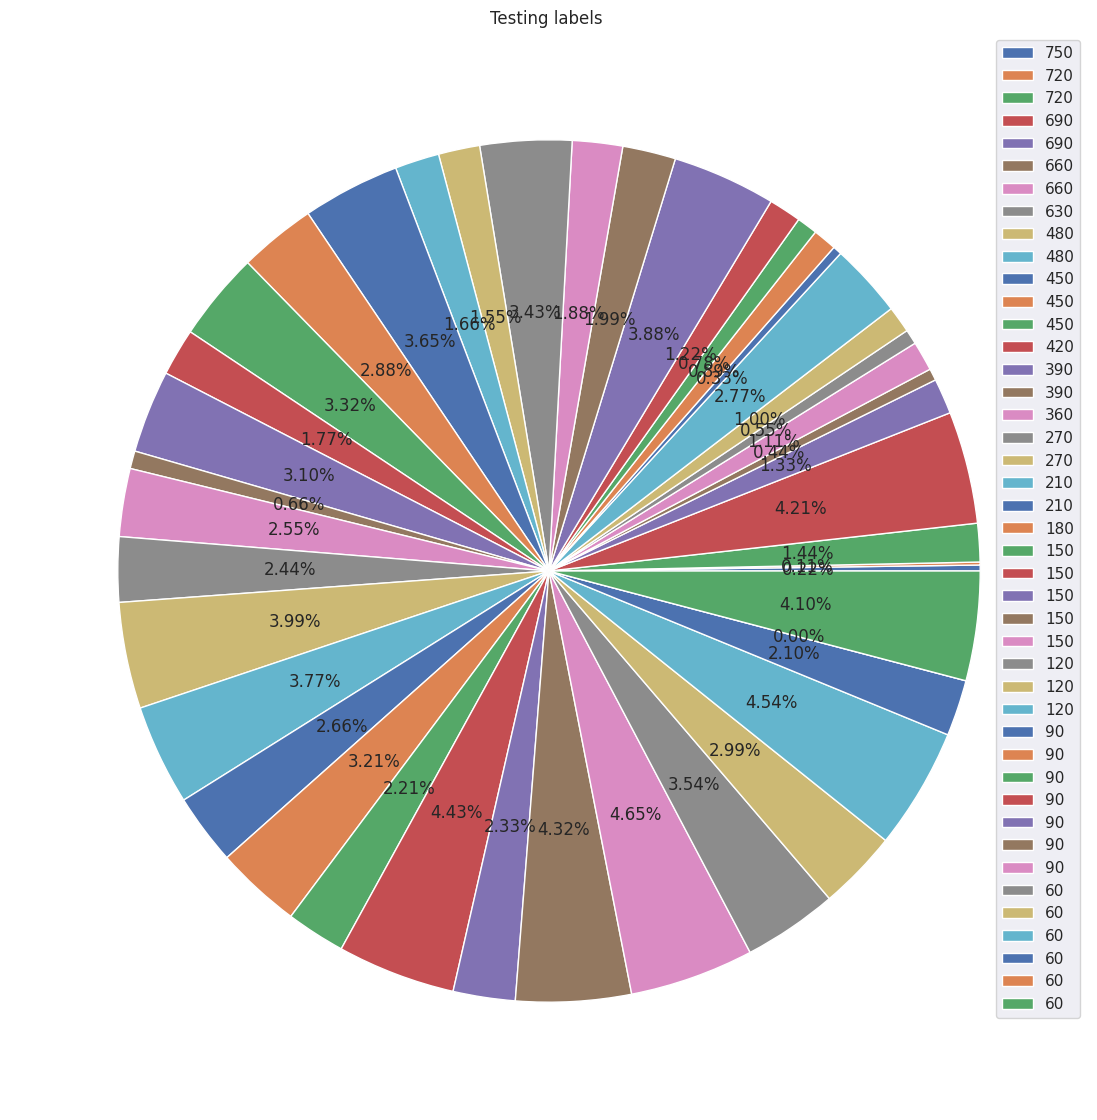

In [14]:
print(test_df['ClassId'].value_counts())

sns.set()
plt.figure(figsize = (14, 14))
plt.pie(x = test_df['ClassId'].value_counts().index, autopct= '%1.2f%%')
plt.legend( labels = test_df['ClassId'].value_counts().values)
plt.title("Testing labels ")
plt.show()

In [15]:
train_size = len(train_df['ClassId'].value_counts().index)
test_size = len(test_df['ClassId'].value_counts().index)


print(f"Training size : {train_size}")
print(f"Testing size : {test_size}")

Training size : 43
Testing size : 43


In [16]:
np.isin(train_df['ClassId'].value_counts().index , test_df['ClassId'].value_counts().index)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [17]:
OUT_SIZE = 43

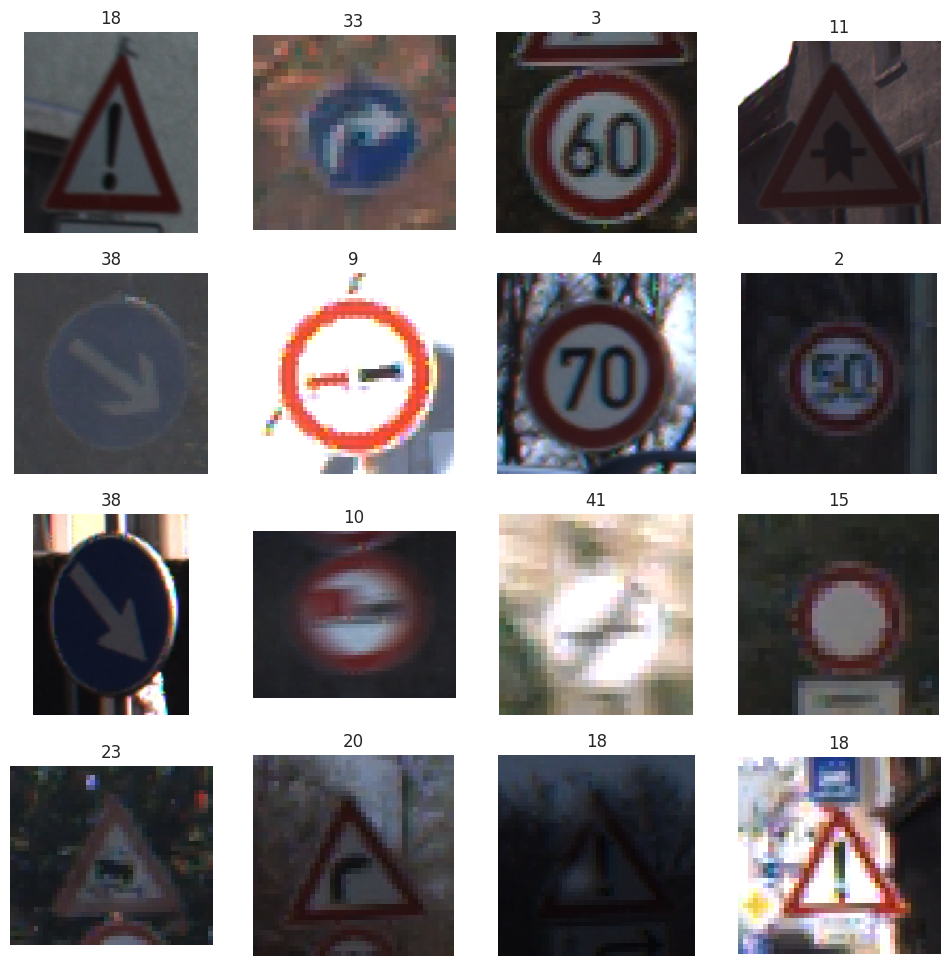

In [18]:
sample_df = train_df.sample(16, random_state=5)
sample_id = sample_df['ClassId']
sample_path = sample_df['Path']
plt.figure(figsize = (12, 12))
for i, j in enumerate(sample_path):
  plt.subplot(4, 4, i + 1)
  img = plt.imread(j)
  plt.axis('off')
  plt.title(sample_id.values[i])
  plt.imshow(img)
plt.show()

In [19]:
minTrainHeight = train_df['Height'].min()
minTrainWidth = train_df['Width'].min()

minTestHeight = test_df['Height'].min()
minTestWidth = test_df['Width'].min()

In [20]:
print(f"Minimun training image height : {minTrainHeight}")
print(f"Minimun training image width : {minTrainWidth}")
print(f"Minimun testing image height : {minTestHeight}")
print(f"Minimun testing image width : {minTestWidth}")

Minimun training image height : 25
Minimun training image width : 25
Minimun testing image height : 25
Minimun testing image width : 25


In [21]:
TARGET_SIZE = [36, 36]
INPUT_SIZE = TARGET_SIZE + [3]

In [22]:
trainX = np.array(train_df['Path'].values)
trainY = np.array(train_df['ClassId'].values)

testX = np.array(test_df['Path'].values)
testY = np.array(test_df['ClassId'].values)

In [23]:
trainY = to_categorical(trainY, num_classes= OUT_SIZE)
testY = to_categorical(testY, num_classes= OUT_SIZE)

In [24]:
train_gen = ImageDataGenerator(rotation_range=10,
                            rescale = 1./255,
                            zoom_range=0.15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.15,
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode="nearest"
                            )


test_gen = ImageDataGenerator(rescale = 1./255)

In [25]:
train_df['ClassId'] = train_df['ClassId'].astype('str')
test_df['ClassId'] = test_df['ClassId'].astype('str')

In [26]:
train_generator = train_gen.flow_from_dataframe(train_df,
                                                x_col='Path',
                                                y_col='ClassId',
                                                target_size = TARGET_SIZE,
                                                class_mode='categorical',
                                                shuffle = True,
                                                batch_size = 32,
                                                color_mode = 'rgb'
                                                )

test_generator = train_gen.flow_from_dataframe(test_df,
                                                x_col='Path',
                                                y_col='ClassId',
                                                target_size = TARGET_SIZE,
                                                class_mode='categorical',
                                                shuffle = True,
                                                batch_size = 32,
                                                color_mode = 'rgb'
                                                )

Found 39209 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.


In [27]:
trainingSteps = train_generator.n // train_generator.batch_size
validationSteps = test_generator.n // test_generator.batch_size

print(f"Training epoch has {trainingSteps} steps.")
print(f"Validation epoch has {validationSteps} steps.")

Training epoch has 1225 steps.
Validation epoch has 394 steps.


In [28]:
VGG = VGG16(include_top=False, weights = 'imagenet', input_shape= INPUT_SIZE)

58889256/58889256 [==============================] - 0s 0us/step


In [29]:
for layer in VGG.layers:
  layer.trainable = False

In [30]:
x = Flatten()(VGG.output)
x = Dense(units = OUT_SIZE, activation = 'softmax')(x)


model = Model(inputs = [VGG.input], outputs = [x])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36, 36, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 36, 36, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 36, 36, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 18, 18, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 18, 18, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 18, 18, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 9, 9, 128)         0     

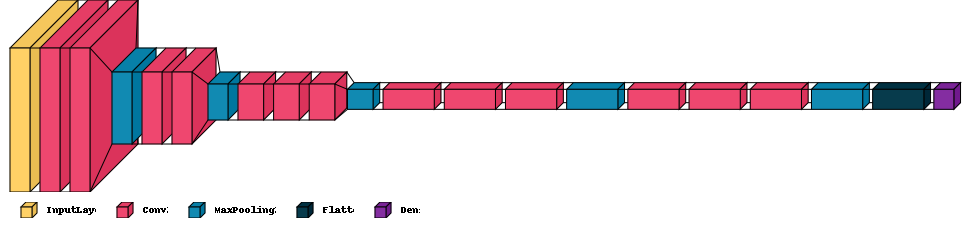

In [31]:
visualkeras.layered_view(model, legend = True)

In [32]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

In [33]:
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=15,
                              verbose=1)

reduceLr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=5,
                              verbose=1,
                              min_lr=0.000001,
                              model='auto')

modelCheck = ModelCheckpoint("model_weights.h5",
                             monitor="val_accuracy",
                             save_weights_only=True,
                             mode="max",
                             verbose=1)


callBacks = [earlyStopping, reduceLr, modelCheck, PlotLossesKerasTF()]

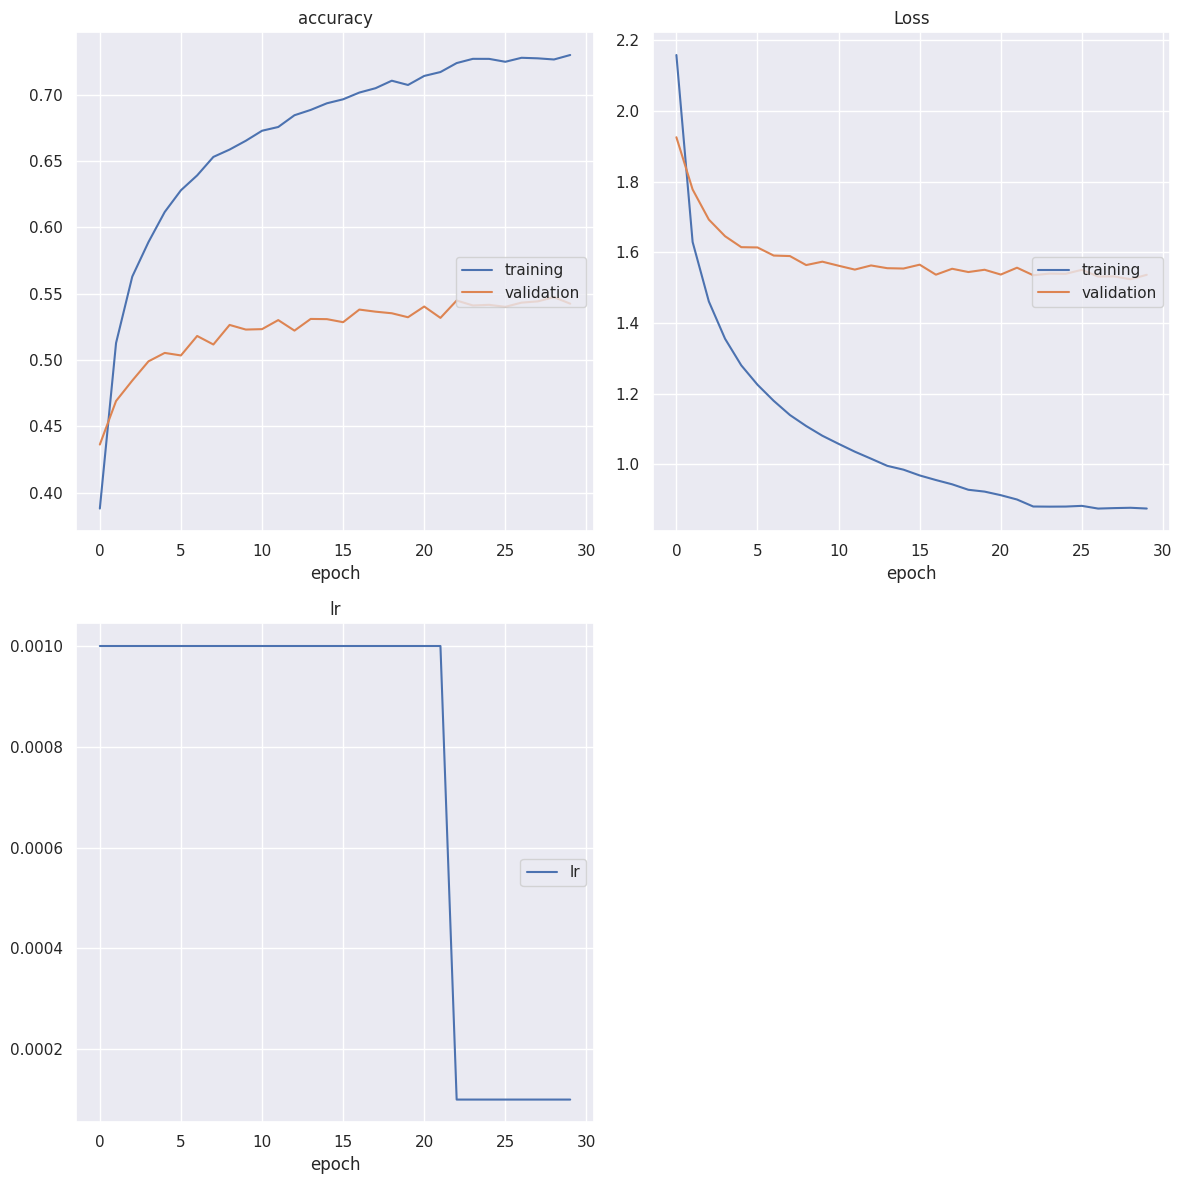

accuracy
	training         	 (min:    0.388, max:    0.730, cur:    0.730)
	validation       	 (min:    0.436, max:    0.547, cur:    0.542)
Loss
	training         	 (min:    0.875, max:    2.158, cur:    0.875)
	validation       	 (min:    1.524, max:    1.926, cur:    1.536)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
1225/1225 [==============================] - 68s 56ms/step - loss: 0.8753 - accuracy: 0.7299 - val_loss: 1.5364 - val_accuracy: 0.5424 - lr: 1.0000e-04


In [34]:
modelHist = model.fit_generator(train_generator,
                    steps_per_epoch= trainingSteps,
                    epochs = 30,
                    verbose = 1,
                    callbacks=callBacks,
                    validation_data=test_generator,
                    validation_steps= validationSteps)